Best DBSCAN parameters: eps=0.03, min_samples=3
Best DB Index: 0.021881352570528024
Best Silhouette Score: 0.9811536234732471
Best Adjusted Rand Index: 0.0
Best V-Measure: 0.0
Best Fowlkes-Mallows Index: 0.4264014327112209


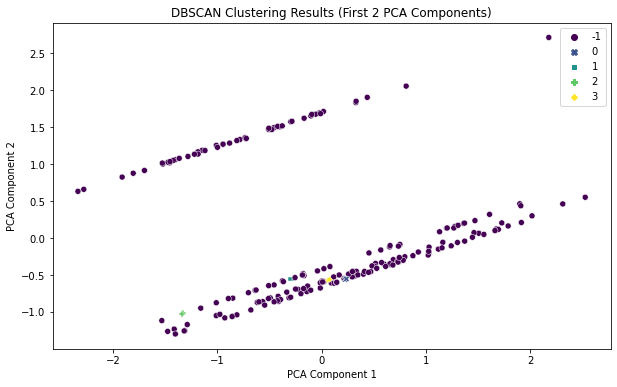

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler  
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, adjusted_rand_score, v_measure_score, fowlkes_mallows_score
import matplotlib.pyplot as plt
import seaborn as sns


customers_df = pd.read_csv('Details/Customers.csv') 
products_df = pd.read_csv('Details/Products.csv') 
transactions_df = pd.read_csv('Details/Transactions.csv') 


transaction_summary = transactions_df.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count"
}).rename(columns={
    "TotalValue": "TotalSpent",
    "TransactionID": "TransactionCount"
}).reset_index()


merged_data = pd.merge(customers_df, transaction_summary, on="CustomerID", how="inner")


merged_data = pd.get_dummies(merged_data, columns=["Region"], drop_first=True)


features = merged_data[["TotalSpent", "TransactionCount"] + 
                       [col for col in merged_data.columns if col.startswith("Region_")]]


features = features.apply(pd.to_numeric, errors='coerce')


features.fillna(features.mean(), inplace=True)


scaler = RobustScaler()
scaled_data = scaler.fit_transform(features)


num_features = scaled_data.shape[1]
pca_components = min(num_features, 10)  
pca = PCA(n_components=pca_components)
reduced_data = pca.fit_transform(scaled_data)


best_db_index = float('inf')
best_silhouette_score = -1  
best_ari = -1
best_v_measure = -1
best_fmi = -1
best_eps = None
best_min_samples = None
best_labels = None


for eps in np.arange(0.01, 0.5, 0.01):  
    for min_samples in range(3, 15):  
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(reduced_data)
        
        
        non_noise_mask = labels != -1
        filtered_data = reduced_data[non_noise_mask]
        filtered_labels = labels[non_noise_mask]
        
        if len(set(filtered_labels)) > 1:  
            
            db_index = davies_bouldin_score(filtered_data, filtered_labels)
            silhouette = silhouette_score(filtered_data, filtered_labels)
            ari = adjusted_rand_score(filtered_labels, np.zeros_like(filtered_labels))  
            v_measure = v_measure_score(filtered_labels, np.zeros_like(filtered_labels))  
            fmi = fowlkes_mallows_score(filtered_labels, np.zeros_like(filtered_labels))  
            
            
            if db_index < best_db_index and silhouette > best_silhouette_score and ari > best_ari and \
               v_measure > best_v_measure and fmi > best_fmi:
                best_db_index = db_index
                best_silhouette_score = silhouette
                best_ari = ari
                best_v_measure = v_measure
                best_fmi = fmi
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels


print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Best DB Index: {best_db_index}")
print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best Adjusted Rand Index: {best_ari}")
print(f"Best V-Measure: {best_v_measure}")
print(f"Best Fowlkes-Mallows Index: {best_fmi}")


merged_data["Cluster"] = best_labels


cluster_data = merged_data[merged_data["Cluster"] != -1]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    hue=best_labels,
    palette="viridis",
    style=best_labels,
    legend="full"
)
plt.title("DBSCAN Clustering Results (First 2 PCA Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
